<a href="https://colab.research.google.com/github/u-10bei/Population_Projections/blob/main/ipynb/R_StateSpace4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages( "KFAS" )
install.packages( "reshape2" )

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘Rcpp’




目的：日本の将来人口を、Ｒを使って推計してみます。  
　　　今回は人口方程式の考え方に沿って時系列分析します。  
　　　ただし、死亡数は年齢３区分ごとに、一旦死亡率を求め計算します。

>$t$年から$a$年後の人口$(P_{t+a})$は、基準人口$(P_t)$に$t$年から$t+a$年までの  
出生数$(B)$を加え死亡数$(D)$を減じ  
国籍取得数$(IN)$を加え国籍離脱数$(ON)$を減じたものです。  
$P_{t+a}={P_t}+{B_{t\to t+a}}－{D_{t\to t+a}}$
$+{IN_{t\to t+a}}-{ON_{t\to t+a}}$  

# 手順１　データの収集


*  [データ保存場所](https://raw.githubusercontent.com/u-10bei/Population_Projections/main/population_jp_year.csv)
*  各年１０月１日人口： [「人口推計」（総務省統計局）](https://www.stat.go.jp/data/jinsui/2.html)を加工して作成しました。
*  出生・死亡 [「人口動態調査」（厚生労働省）](https://www.mhlw.go.jp/toukei/list/81-1a.html)を加工して作成しました。


データを読み込んで、時系列予測に必要な形式に変換します。  
状態空間モデルの分析パッケージ[KFAS](https://github.com/helske/KFAS)を使います。

In [2]:
# 該当リポジトリを変数に格納
repo = 
  c( "https://raw.githubusercontent.com/u-10bei/Population_Projections/" )

# 人口推計に使うデータの格納場所を変数に格納
popURL = 
  c( "main/data/population_jp_year.csv" )

# ライブラリの読み込み
library( readr )
library( dplyr )

repo |>
  paste0( popURL ) |>                     # 読み込むアドレスの編集
  read_csv( show_col_types = FALSE ) |>   # ネット上のファイル読み込み
  mutate( Year = {
    paste0( Year, "-10-01" ) |>           # １０月１日現在の日付型にする
      as.Date()},
          Dr = Death / Total,             # 年代別の死亡率計算
          Dru14 = Du14 / Tu14,
          Drm = Dm / Tm,
          Dro65 = Do65 / To65 ) ->
pop_df4 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# 手順２　データの可視化

まず、データをプロットしてみます。

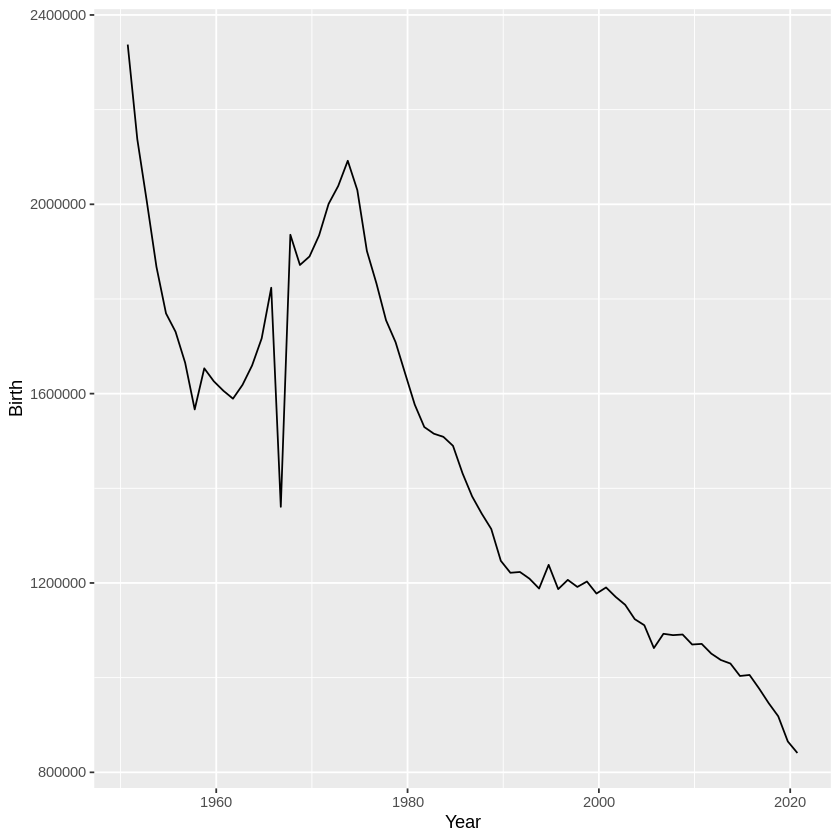

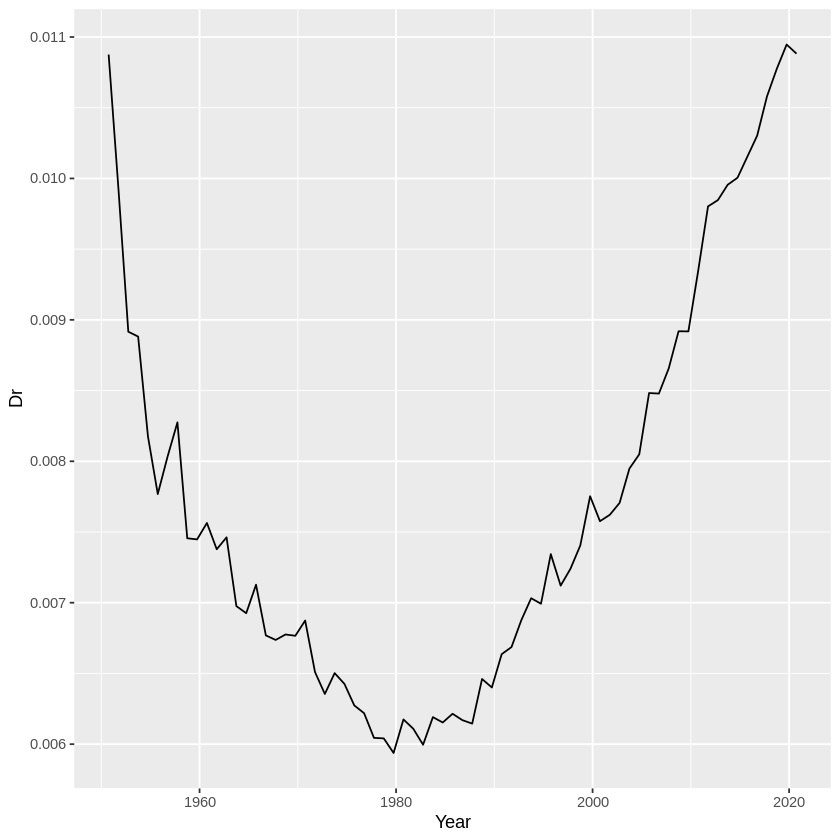

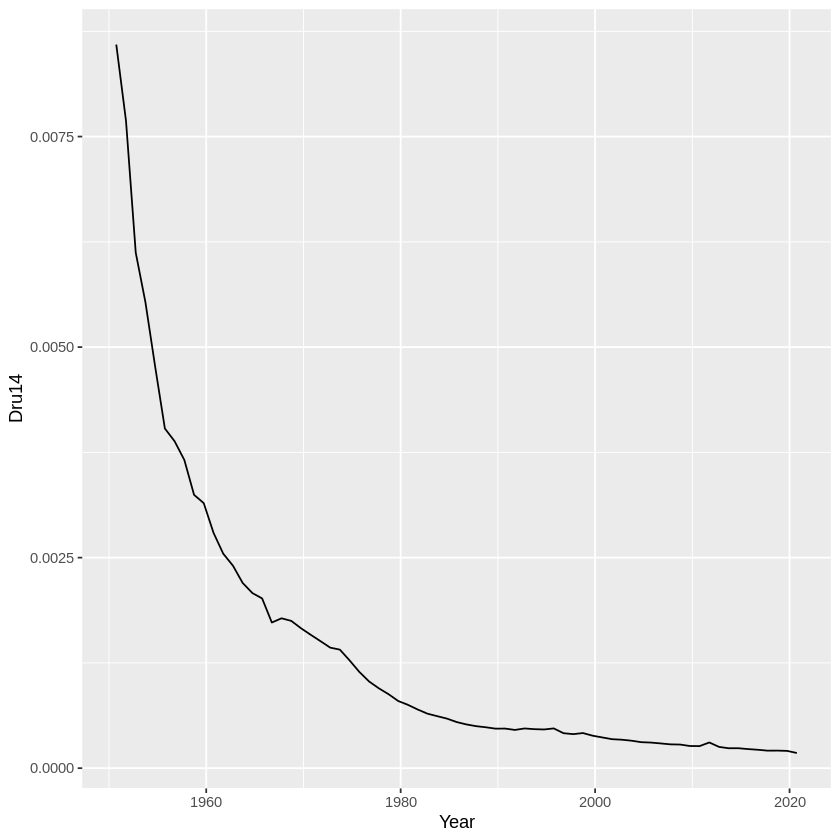

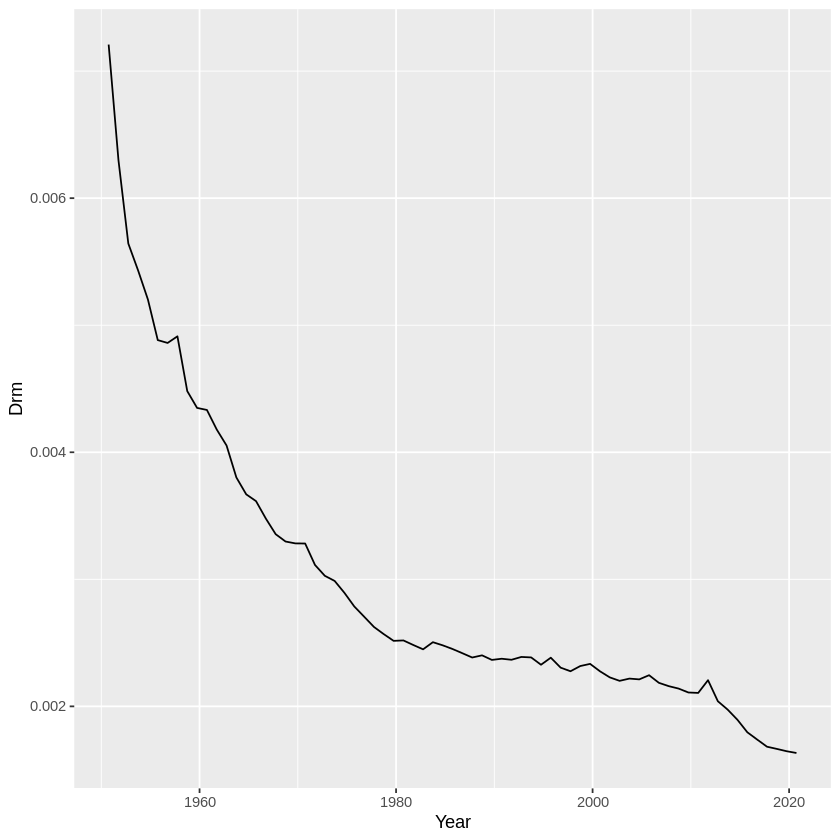

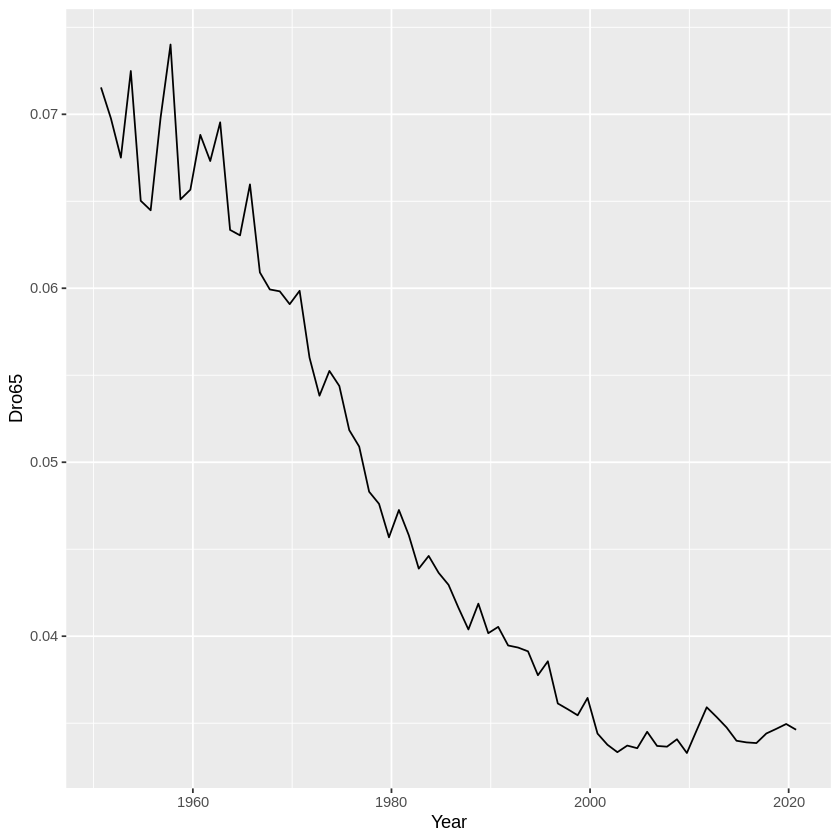

In [3]:
# ライブラリの読み込み
library( ggplot2 )

# 出生数、死亡率のグラフ
pop_df4 |>
  ggplot( aes( x = Year,
               y = Birth )) +
  geom_line() 
pop_df4 |>
  ggplot( aes( x = Year,
               y = Dr )) +
  geom_line()
pop_df4 |>
  ggplot( aes( x = Year,
               y = Dru14 )) +
  geom_line()
pop_df4 |>
  ggplot( aes( x = Year,
               y = Drm )) +
  geom_line()
pop_df4 |>
  ggplot( aes( x = Year,
               y = Dro65 )) +
  geom_line()

全体の死亡率が１９９０年代を境に上昇しているのに対し、  
年齢３区分で分類すると、死亡率はいずれも低下している事が分かります。  
次に、自己相関を確認してみます。

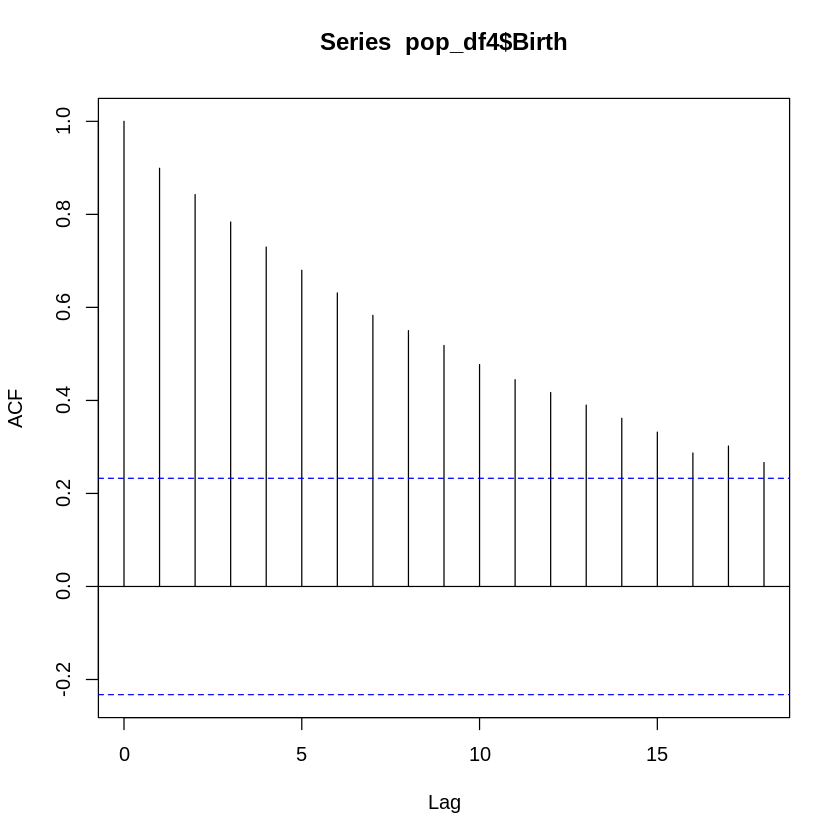

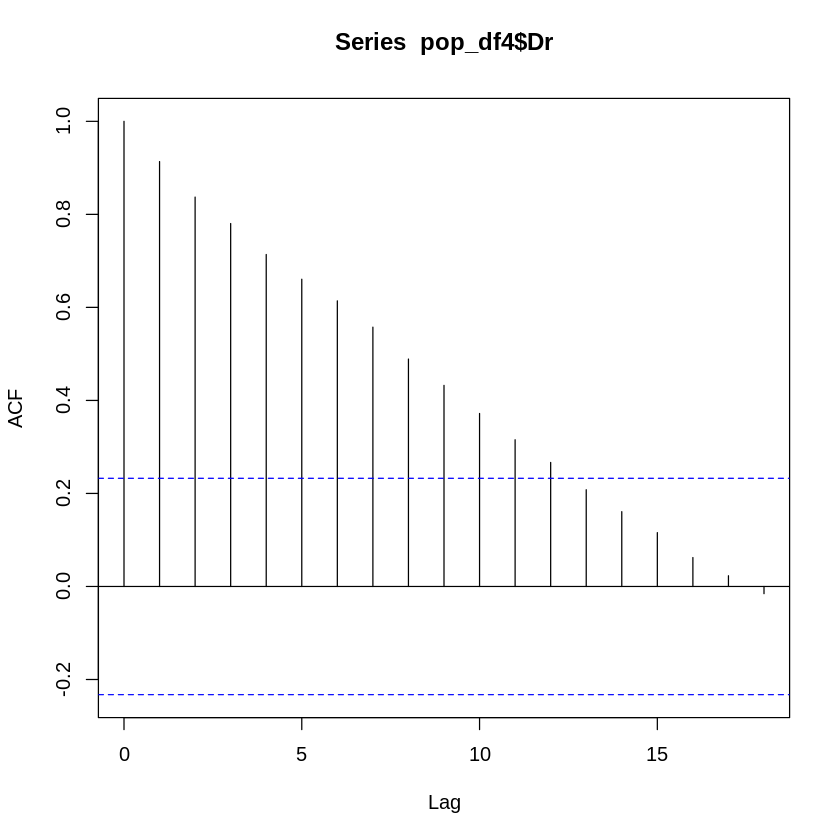

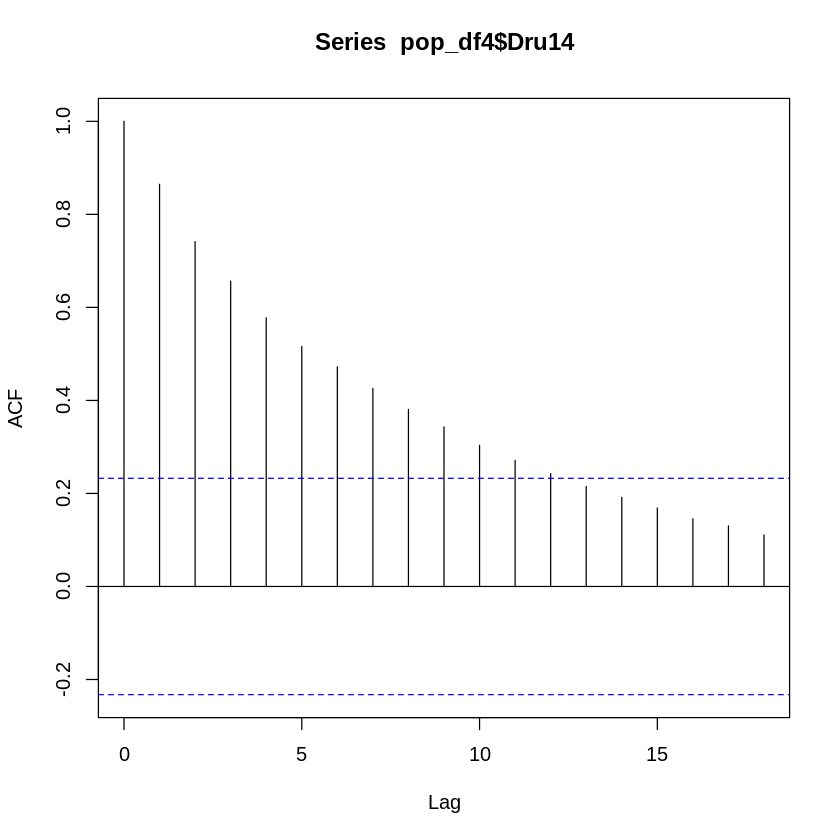

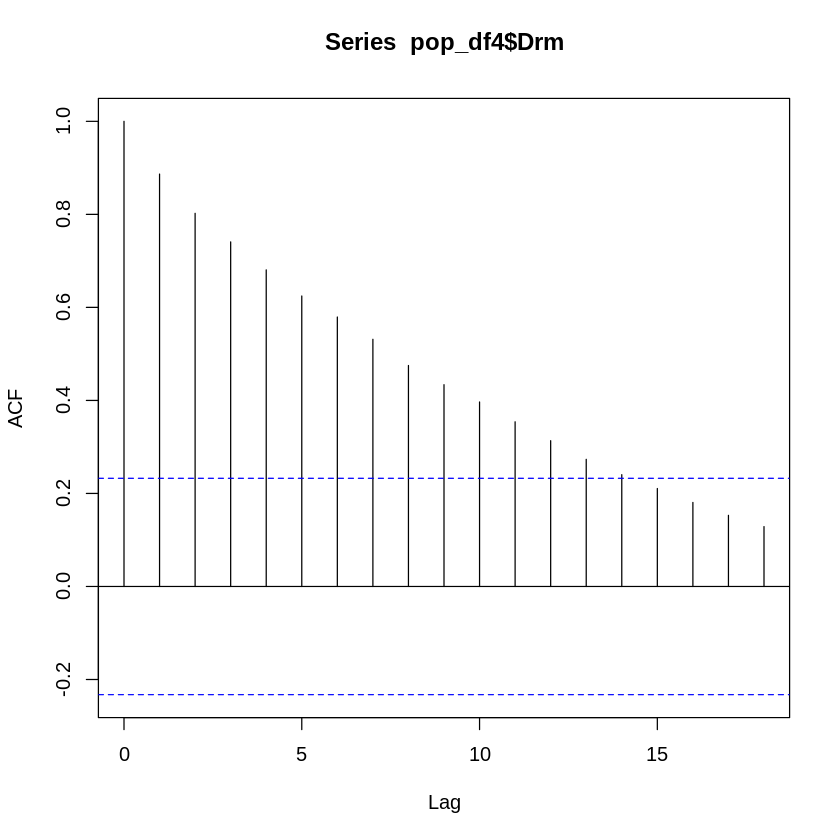

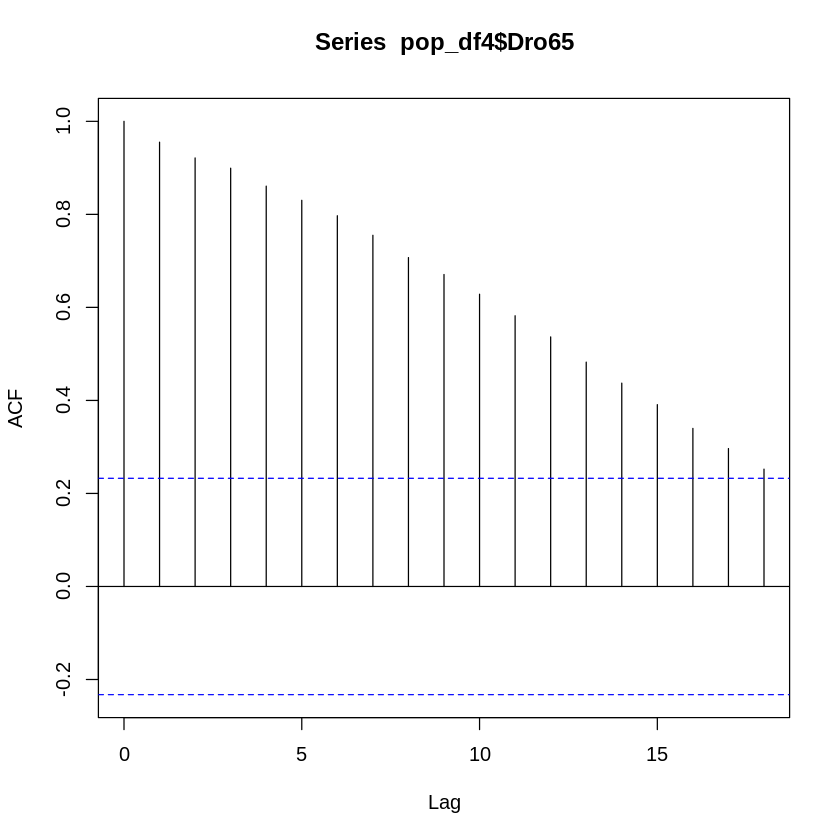

In [4]:
# 自己相関のグラフ
pop_df4$Birth |>
  acf()
pop_df4$Dr |>
  acf()
pop_df4$Dru14 |>
  acf()
pop_df4$Drm |>
  acf()
pop_df4$Dro65 |>
  acf()

なんとなく相関はありそう。かつ、１年前のデータとの強い相関がありそうです。  
偏自己相関も確認しておきます。

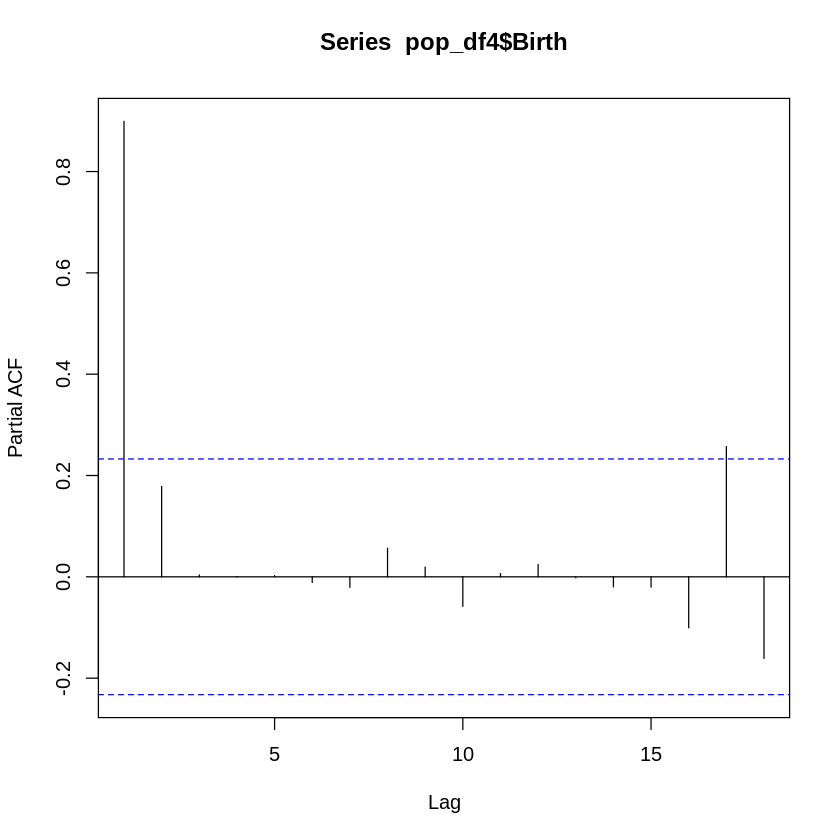

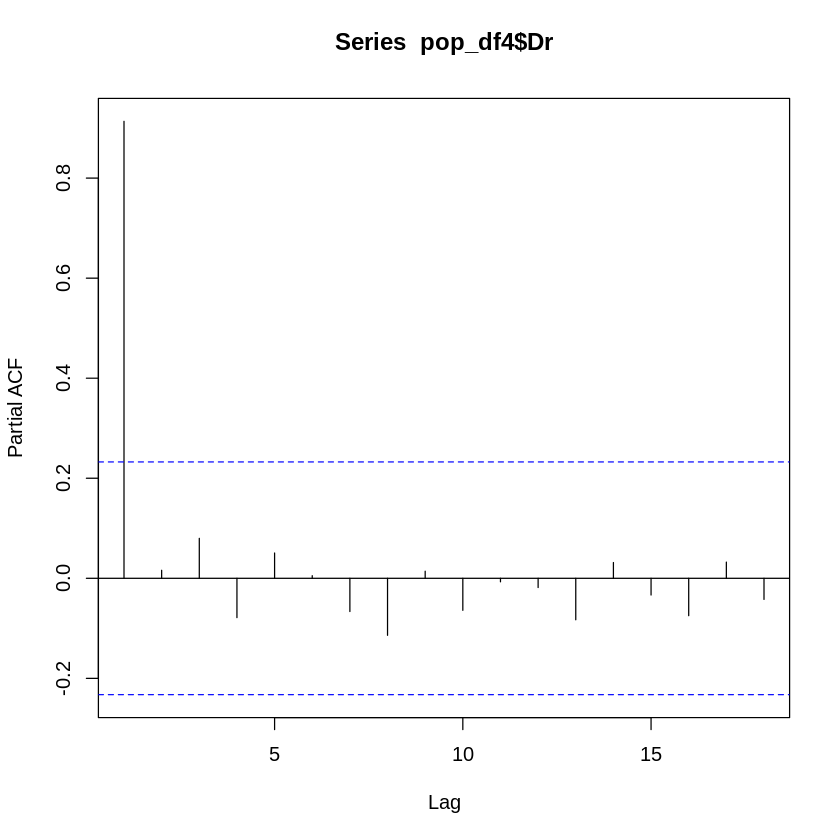

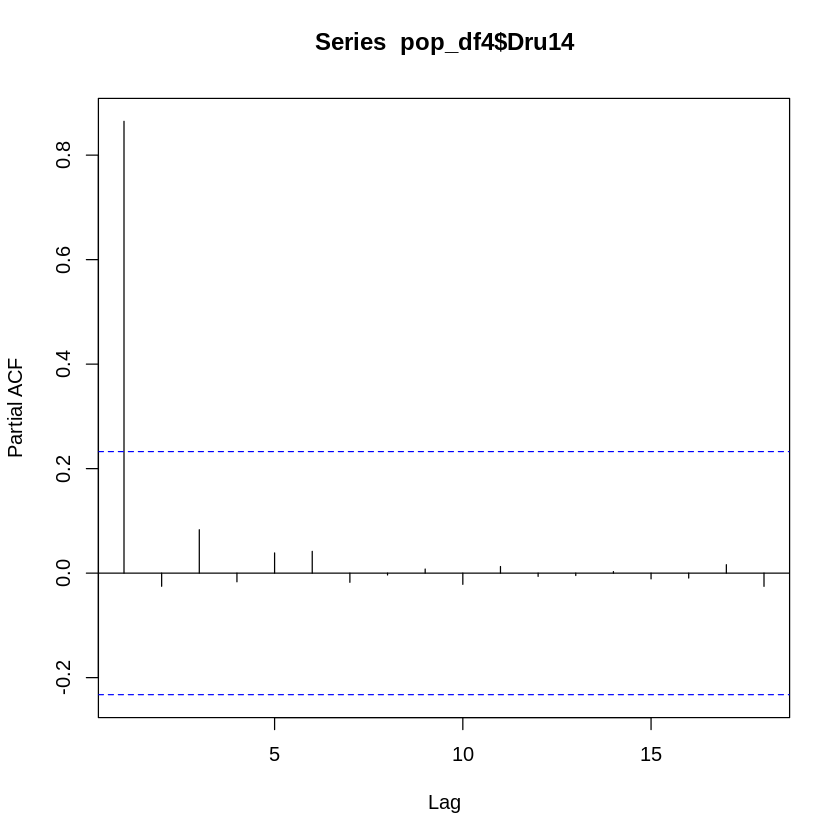

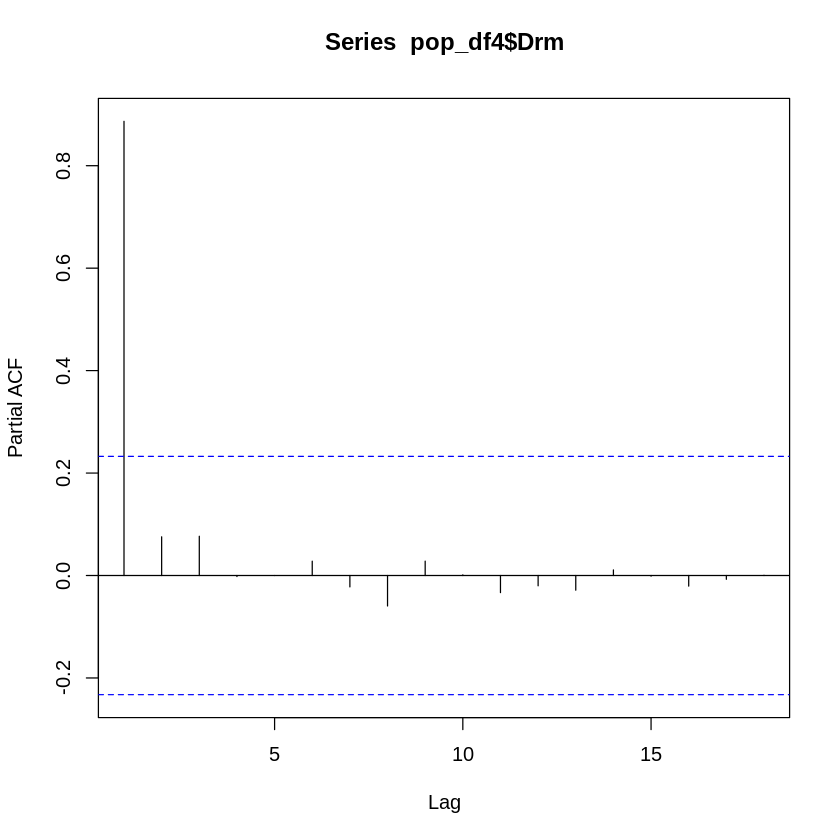

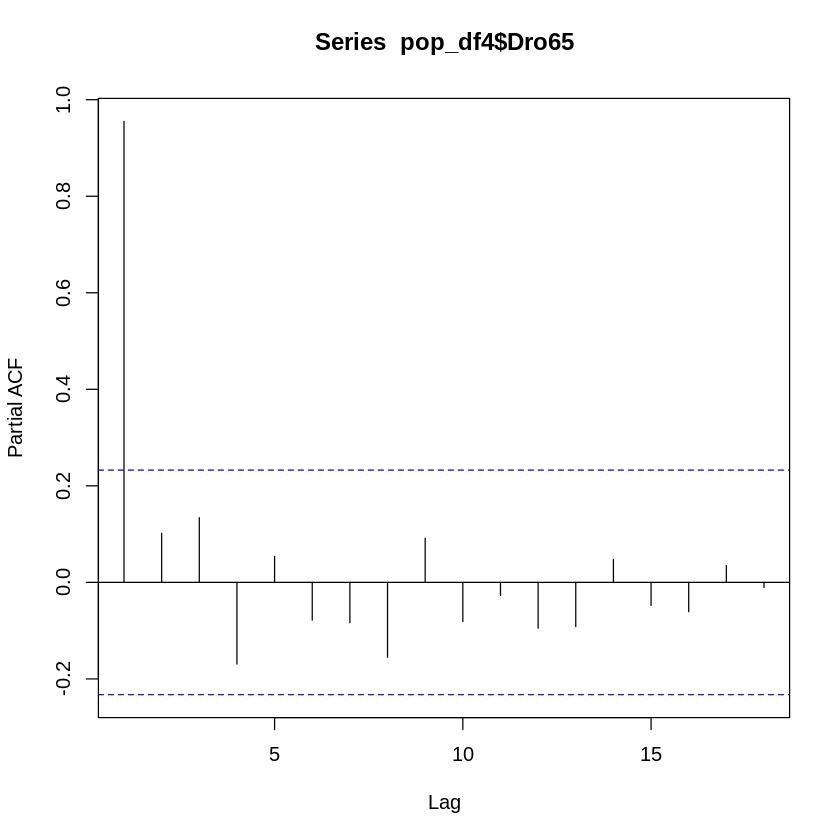

In [5]:
# 偏自己相関のグラフ
pop_df4$Birth |>
  pacf()
pop_df4$Dr |>
  pacf()
pop_df4$Dru14 |>
  pacf()
pop_df4$Drm |>
  pacf()
pop_df4$Dro65 |>
  pacf()

# 手順３　学習データと予測データの分類

２０１５年までの人口データと２０１４年までの出生、死亡データを学習データとし、  
その後５年間のデータを予測データとします。

In [6]:
# 学習データと予測データ
prow_test2 = 6
prow_train2 = nrow( pop_df4 ) - prow_test2

pop_df4 |>
  tail( n = prow_test2 ) ->
pop_test4

pop_df4 |>
  head( n = prow_train2 ) ->
pop_train4

# 手順４　状態空間モデルによる予測

ローカル線形トレンドモデルを使用して、予測をしてみます。

In [7]:
# ライブラリの読み込み
library( KFAS )

# モデル構造の決定
SSModel( H = NA,
         pop_train4$Birth ~ SSMtrend( degree = 2,
                                     Q = list( NA, NA ))) |>
  fitSSM( inits = c( 1, 1, 1 )) ->        # パラメタ推定
fit_trend_B

SSModel( H = NA,
         pop_train4$Dru14 ~ SSMtrend( degree = 2,
                                   Q = list( NA, NA ))) |>
  fitSSM( inits = c( 1, 1, 1 )) ->        # パラメタ推定
fit_trend_Dru

SSModel( H = NA,
         pop_train4$Drm ~ SSMtrend( degree = 2,
                                      Q = list( NA, NA ))) |>
  fitSSM( inits = c( 1, 1, 1 )) ->        # パラメタ推定
fit_trend_Drm

SSModel( H = NA,
         pop_train4$Dro65 ~ SSMtrend( degree = 2,
                                      Q = list( NA, NA ))) |>
  fitSSM( inits = c( 1, 1, 1 )) ->        # パラメタ推定
fit_trend_Dro

# 将来予測の結果と予測区間
fit_trend_B$model |>
  predict( interval = "prediction",
           n.ahead = 6 ) |>
  as.data.frame() ->
forecast_trend_B

fit_trend_Dru$model |>
  predict( interval = "prediction",
           n.ahead = 6 ) |>
  as.data.frame() ->
forecast_trend_Dru

fit_trend_Drm$model |>
  predict( interval = "prediction",
           n.ahead = 6 ) |>
  as.data.frame() ->
forecast_trend_Drm

fit_trend_Dro$model |>
  predict( interval = "prediction",
           n.ahead = 6 ) |>
  as.data.frame() ->
forecast_trend_Dro

Please cite KFAS in publications by using: 

  Jouni Helske (2017). KFAS: Exponential Family State Space Models in R. Journal of Statistical Software, 78(10), 1-39. doi:10.18637/jss.v078.i10.



# 手順５　出生数、死亡数から総人口を計算

昨年の人口＋出生－死亡を計算します。

In [9]:
# 出生数、死亡数の合算
pop_test4 |>
  rename( "forecast_BD" = Total ) ->
pop_SS_f4

forecast_trend_B |>
  select( fit ) ->
pop_SS_f4[, 3 ]

forecast_trend_Dru |>
  select( fit ) ->
pop_SS_f4[, 12 ]

forecast_trend_Drm |>
  select( fit ) ->
pop_SS_f4[, 13 ]

forecast_trend_Dro |>
  select( fit ) ->
pop_SS_f4[, 14 ]
pop_SS_f4 |>
  mutate( Du14 = Tu14  * Dru14,
          Dm = Tm * Drm,
          Do65 = To65 * Dro65,
          forecast_BD = lag( forecast_BD +
                               Birth -
                               Du14 -
                               Dm - 
                               Do65 )) ->
pop_SS_f4

# 手順６　結果比較

それでは、実データや「本家」社会保障人口問題研究所の推計結果と比較してみます。

Year,Total,forecast_BD,DMBM,DMBH,DLBM,DLBH
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-10-01,126933000,126787090,126838000,126864000,126912000,126938000
2017-10-01,126706000,126612713,126532000,126605000,126704000,126777000
2018-10-01,126443000,126379098,126177000,126315000,126441000,126580000
2019-10-01,126167000,126114175,125773000,125998000,126125000,126351000
2020-10-01,126146000,125840173,125325000,125658000,125761000,126094000


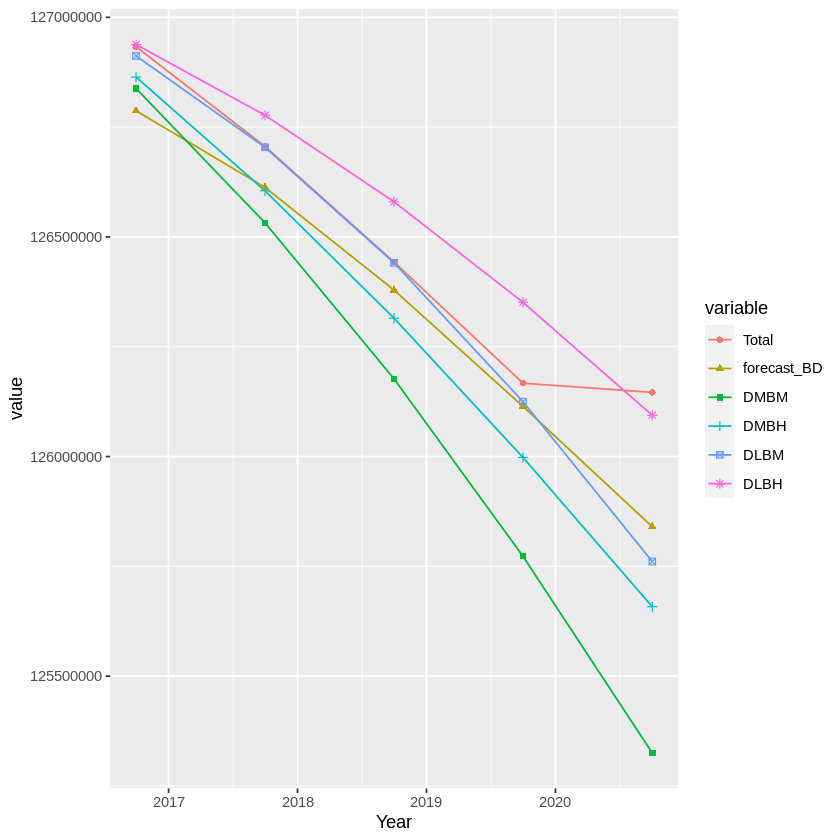

In [10]:
# 社人研予測との比較
# 該当ＵＲＬを変数に格納
ipssURL = 
  c( "main/data/forecast_ipss.csv" )

repo |>
  paste0( ipssURL ) |>                    # 読み込むアドレスの編集
  read_csv( show_col_types = FALSE ) |>   # ネット上のファイル読み込み
  mutate( Year = {
    paste0( Year, "-10-01" ) |>           # １０月１日現在の日付型にする
      as.Date()}
  ) ->
ipss_test

pop_SS_f4[ , 1:2 ] |>
  inner_join( pop_test4, by = "Year") |>
  inner_join( ipss_test, by = "Year") |>
  select( Year,
          Total,
          forecast_BD,
          DMBM,
          DMBH,
          DLBM,
          DLBH ) ->
join_test4
join_test4

# ライブラリの読み込み
library( reshape2 )

# 描画
join_test4 |> 
  melt( id = "Year",
        measure = c( "Total",
                     "forecast_BD",
                     "DMBM",
                     "DMBH",
                     "DLBM",
                     "DLBH" )) |>
  ggplot( aes( x = Year,
               y = value,
               shape = variable,
               colour = variable,
               group = variable )) +
  geom_line() +
  geom_point()

今度も少し低めに出てしまいました。  
死亡率の影響はわずかだったようです。

# 次のステップ


*   同じ事をPythonでやってみる。　->　こちら
*   人口３区分でコホート分析する　->　こちら
